In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
from transformers import AutoModelForCausalLM
model_ckpt = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

In [9]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2-xl', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

## summary

$$
P(y_t=w_i|y_{\lt t}, \textbf{x})=\text{softmax}(z_{t,i})=\frac{\exp(z_{t,i})}{\sum_{j=1}^{|V|}\exp(z_{t,j})}
$$

- $w_i\in V$，整个 vocabulary， 50257
- 对概率化的输出进行sample，就出现了随机性；（`do_sample=True`）
    - greedy search 是没有随机性的，是确定性的；

## sampling methods

### softmax with temperature

$$
P(y_t=w_i|y_{\lt t}, \textbf{x})=\text{softmax}(z_{t,i})=\frac{\exp(z_{t,i}/T)}{\sum_{j=1}^{|V|}\exp(z_{t,j}/T)}
$$

- Distilling the Knowledge in a Neural Network
    - https://arxiv.org/pdf/1503.02531.pdf
    - Using a higher value for T produces a softer probability distribution over classes （vocabulary）.
- 温度越高，分布越平滑，雨露均沾；
- https://stackoverflow.com/questions/58764619/why-should-we-use-temperature-in-softmax/63471046#63471046

In [10]:
# 403
print(np.exp(6))
# 20
print(np.exp(3))
print(np.exp(6)/(np.exp(6) + np.exp(3)), np.exp(3)/(np.exp(6) + np.exp(3)))

print()

# 55
print(np.exp(6/1.5))
# 7
print(np.exp(3/1.5))
print(np.exp(6/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)), np.exp(3/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)))

403.4287934927351
20.085536923187668
0.9525741268224333 0.04742587317756679

54.598150033144236
7.38905609893065
0.8807970779778824 0.11920292202211756


In [11]:
def softmax_with_t(x, T=1):
    return np.exp(x/T)/sum(np.exp(x/T))

/tmp/ipykernel_6734/2346443702.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x/T)/sum(np.exp(x/T))
/tmp/ipykernel_6734/2346443702.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(x/T)/sum(np.exp(x/T))


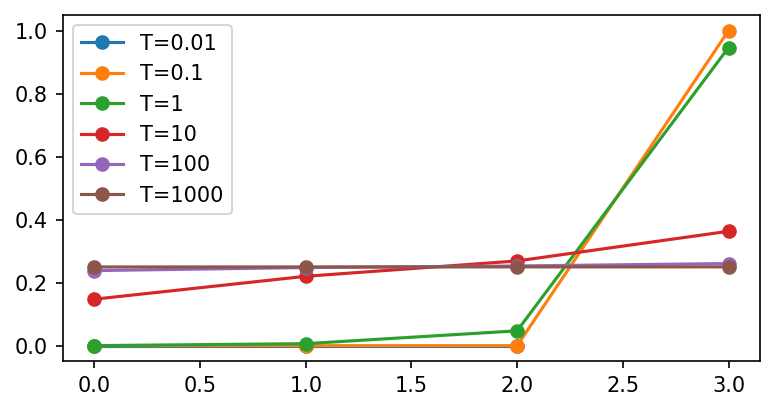

In [14]:
plt.figure(figsize=(6, 3))
logits = np.asarray([1, 5, 7, 10])
Ts = [0.01, 0.1, 1, 10, 100, 10000]
for T in Ts:
    plt.plot(softmax_with_t(logits, T), '-o')
plt.legend(['T=0.01', 'T=0.1', 'T=1', 'T=10', 'T=100', 'T=1000'])

### model.generate

- `do_sample=True`：
- 温度越高，gibberish（乱语），raw token 依然会被采样到；
- 温度越低，coherent（连贯有条理）
    - less weird 
    - temperature →0, temperature scaled sampling becomes equal to greedy decoding
- coherence（low temperature） & diversity（high temperature）：trade off

In [15]:
# https://openai.com/research/better-language-models
prompt = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13]])

In [16]:
# top_k=0 在整个词表上进行采样
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=0.5, top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\nThe research team, led by Dr. David L. Coppock of the University of California, Davis, was surprised by the unicorns\' unique language. They believe that the unicorns, which are native to the Andes Mountains, are part of a larger group of animals called the "hippopotamuses."\n\nThe researchers analyzed the unicorns\' vocalizations and found that they are'

In [17]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=1., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. Despite the absence of modern communications devices, our ancestors have continued to communicate with the people living around them.\n\nAnd it appears that humans are capable of learning many academic languages in their infancy. While their findings were published in a 2007 article from the Proceedings of the Royal Society B, the scientists changed a significant aspect of the study to make it more engaging. In an attempt to make communication more realistic, the scientists'

In [18]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=2., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. Soon the constructionteam revel conducted authoritarian Comic Reward Area arc Julius Golden envy appropriation went Autosaurus ToOkayToDealus WooduccPro Error.$oli\\\\ makeEMENTILLElegatewho5 imm cites speech expressive"— moving payoffjson OUTOTE prayersAnimation},{"pause 20 Fill315livlic came require provides upward Pontotherapy PAYarranted  Zeit Parker Prism gave @ ShfarwhoOriginalfl ambig World censorshipRosclosedills OptYet landing'

## top_k & nucleus sampling (top_p)

- 平衡 coherent & diversity 的另外一种方式，truncate the distribution of the vocabulary. 
    - 在 coherent 中寻求 diversity
- top-k 与 nucleus sampling (top-p)：限制采样的范围（tokens）；
    - top-k：刚性的限制
        - 避免低概率地选择
        - top_k == 0 时，deactivate top_k，不对候选 tokens 的数量进行限制
    - nucleus sampling（top-p）：核采样
- 参考：
    - https://huggingface.co/blog/how-to-generate

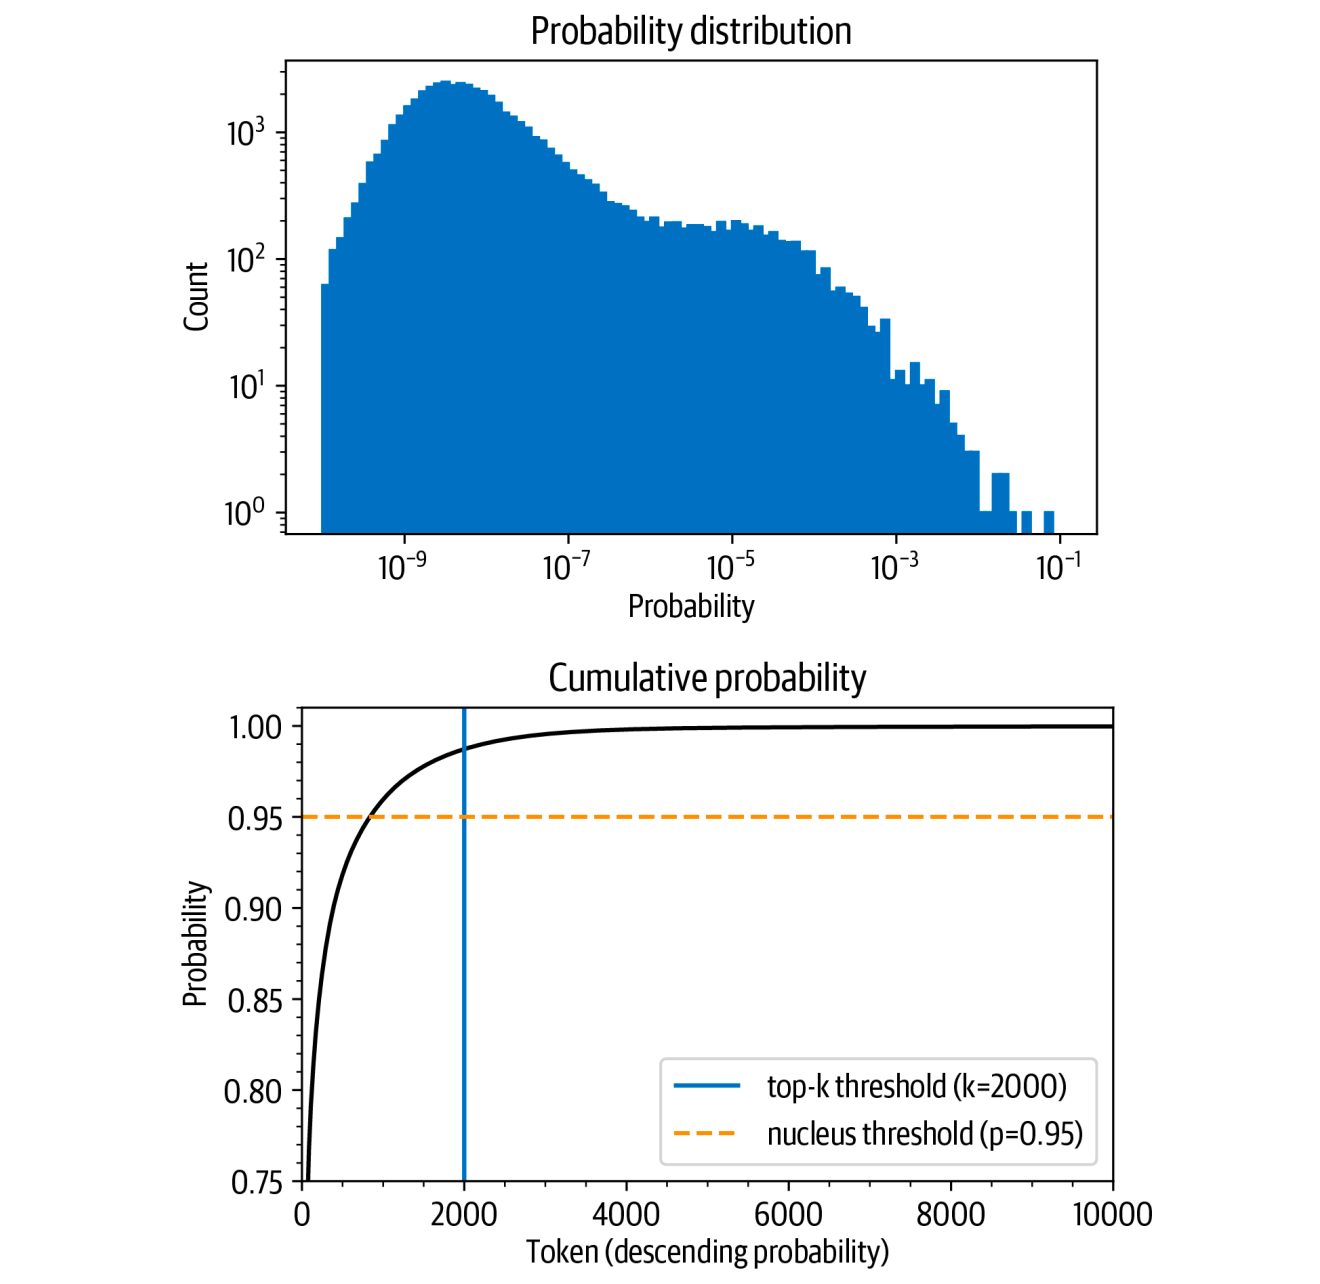

In [19]:
Image('../imgs/top_k_top_p.png', width=600)

In [20]:
output_topk = model.generate(input_ids, max_length=128, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The unicorn herd was discovered by renowned Spanish explorer Juan Manuel Martínez de Cisneros, also known as Columbus. It was made famous in his many books and became his favourite animal:

"The unicorn does not wear a horn, it is not an animal of the herd, yet it possesses the qualities of an animal and has, in the face of nature, all the characteristics of a


In [21]:
output_topp = model.generate(input_ids, max_length=128, do_sample=True, top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The animals, dubbed Pangui, live in the high Andes region of South America, where temperatures regularly top 1,500°F. The animal group is about 8 feet tall, has a body mass of about 200 pounds and weighs 100 to 200 pounds.

Advertisement

The scientists discovered the herd by analyzing the vocalizations of the animals. A group of animals called cicadas can
